In [2]:
import os
import gc
import warnings

import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
import scipy as sp
%matplotlib inline

import torch
from torch.optim import Adam
from torch.nn import MSELoss

from deepseries.models import WaveNet
from deepseries.train import Learner
from deepseries.dataset import TimeSeries, Property, Seq2SeqDataLoader

In [4]:
DIR = "./data"
N_ROWS = 100
BATCH_SIZE = 128
DROP_BEFORE = 1200

LAGS = [28]
MAX_LAGS = max(LAGS)


ENC_LEN = 28 * 4
DEC_LEN = 28

VALID_LEN = 28
TEST_LEN = 28

TRAIN_LAST_DAY = 1913
USE_SERIES_LEN = TRAIN_LAST_DAY - DROP_BEFORE + 1 + 28

CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "int16", 'snap_TX': 'int16', 'snap_WI': 'int16' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

# FIRST_DAY = datetime(2011, 1, 29) 
# FORECAST_DAY = datetime(2016,4, 25) 

In [5]:
def load_data():
    label_encoders = {}
    
    prices = pd.read_csv(os.path.join(DIR, "sell_prices.csv"), dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(prices[col].astype(str).fillna("None"))
            prices[col] = label_encoders[col].transform(prices[col].astype(str).fillna("None")).astype("int16")
    
    cal = pd.read_csv(os.path.join(DIR, "calendar.csv"), dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(cal[col].astype(str).fillna("None"))
            cal[col] = label_encoders[col].transform(cal[col].astype(str).fillna("None")).astype("int16")
    
    start_day = max(1, DROP_BEFORE-MAX_LAGS)
    numcols = [f"d_{day}" for day in range(start_day, TRAIN_LAST_DAY+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv(os.path.join(DIR, "sales_train_validation.csv"), 
                     usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            if col not in label_encoders:
                label_encoders[col] = LabelEncoder().fit(dt[col].astype(str).fillna("None"))
            dt[col] = label_encoders[col].transform(dt[col].astype(str).fillna("None")).astype("int16")

    for day in range(TRAIN_LAST_DAY+1, TRAIN_LAST_DAY+28+1):
        dt[f"d_{day}"] = np.nan
    
    product = dt[catcols].copy()
    print(f"product shape {product.shape}")

    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")

    dt = dt.merge(cal[['d', 'wm_yr_wk']], on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    dt['d'] = dt['d'].str.replace('d_', '').astype("int32")
    price = dt.pivot(index="id", columns="d", values="sell_price")
    xy = dt.pivot(index="id", columns="d", values="sales")
    del dt; gc.collect()
    print(f"sale_xy shape {xy.shape}")
    print(f"price shape {price.shape}")

    cal_use_col = ['date', 'wday', 'month', 'year', 'event_name_1',
    'event_type_1', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX',
    'snap_WI']
    cal = cal[cal_use_col]
    cal['year'] = cal['year'] - cal['year'].min()
    cal['quarter'] = cal.date.dt.quarter
    cal = cal.drop("date", axis=1).T
    cal = cal[xy.columns]
    print(f"calendar shape {cal.shape}")
    
    submission = pd.read_csv(os.path.join(DIR, "sample_submission.csv"))
    print(f"submisson shape {submission.shape}")
    return xy, price, cal, product, submission

In [6]:
df_xy, df_price, df_calendar, df_product, df_sub = load_data()

product shape (30490, 6)
sale_xy shape (30490, 770)
price shape (30490, 770)
calendar shape (11, 770)
submisson shape (60980, 29)


## 缺失数据

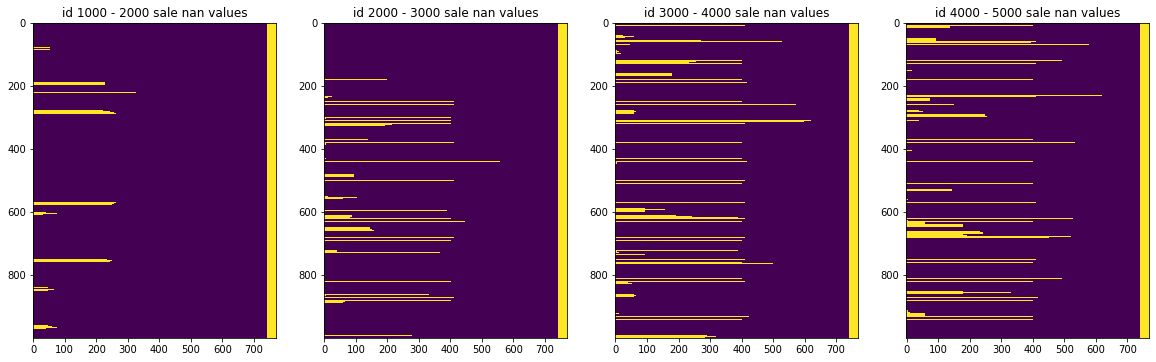

In [5]:
plt.figure(figsize=(20,20))

for i in range(1, 5):
    plt.subplot(int(f'14{i}'))
    plt.imshow(df_xy.isnull().values.astype(int)[i * 1000: (i+1)*1000])
    plt.title(f"id {i * 1000} - {(i+1) * 1000} sale nan values")

In [6]:
id_not_sell = df_xy.isnull().values.astype(int)
id_not_sell[:, -28:] = 0

Text(0.5, 1.0, 'each series num of nan')

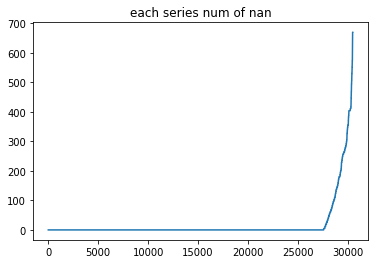

In [7]:
plt.plot(np.sort(id_not_sell.sum(axis=1)))
plt.title("each series num of nan")

In [8]:
pd.Series(id_not_sell.sum(axis=1)).describe()

count    30490.000000
mean        18.223614
std         72.079074
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        670.000000
dtype: float64

没有销售，同样没有价格

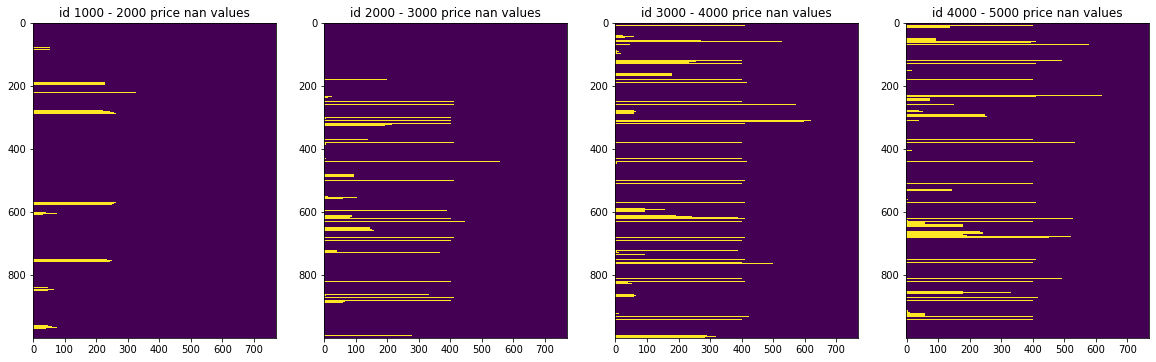

In [9]:
plt.figure(figsize=(20,20))

for i in range(1, 5):
    plt.subplot(int(f'14{i}'))
    plt.imshow(df_price.isnull().values.astype(int)[i * 1000: (i+1)*1000])
    plt.title(f"id {i * 1000} - {(i+1) * 1000} price nan values")

## 数据处理
- log1p
- 序列状态
- 序列统计指标
- 序列标准化

## 特征

### 时间序列状态
- 11_price
- 11_calendar
- 11_is_sell: 是否销售
- 10_is_zero: 是否为0销售
- 10_continue_zero: 为0第N天
- 10_lag_N：前N天销量
- 10_lag_M_rolling_N_mean/std: 窗口统计
- 品类销量
- 日期类

### 序列统计
- id 均值/中位数/偏度/峰度/分位数
- 365/90/30 自相关系数
- 品类下的日销排名/波动排名
- 品类下的价格排名


### Tips
- 特征标记{1,0}{1,0}{1,0}{1,0}
- #1 1 if use in encoder else 0
- #2 1 if use in decoder else 0
- #3 series(1), property(0)
- #4 num(1), categorical(0)

In [7]:
# series
xy = np.log1p(df_xy.values)
price = np.log1p(df_price.values)

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  
C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# series state
xy_nan = np.isnan(xy).astype("float32")
xy_zero = (xy == 0).astype("float32")

In [24]:
# series statistics

xy_valid_masked = np.ma.masked_array(xy, mask=xy_nan.astype(bool))

xy_mean = xy_valid_masked.mean(axis=1).data
xy_std = xy_valid_masked.std(axis=1).data
xy_skew = sp.stats.mstats.skew(xy_valid_masked, axis=1).data
xy_kurt = np.clip(sp.stats.mstats.kurtosis(xy_valid_masked, axis=1).data, None, 10)

In [25]:
# series normalization

xy = np.nan_to_num((xy - np.expand_dims(xy_mean, 1)) / (np.expand_dims(xy_std, 1) + 1e-6), 0.).astype("float32")

In [26]:
# series statistic features

xy_mean_mean = xy_mean.mean()
xy_mean_std = xy_mean.std()
xy_std_mean = xy_std.mean()
xy_std_std = xy_std.std()
xy_skew_mean = xy_skew.mean()
xy_skew_std = xy_skew.std()
xy_kurt_mean = xy_kurt.mean()
xy_kurt_std = xy_kurt.std()

f1101_xy_mean = (xy_mean - xy_mean_mean) / xy_mean_std
f1101_xy_std = (xy_std - xy_std_mean) / xy_std_std
f1101_xy_skew = (xy_skew - xy_skew_mean) / xy_skew_std
f1101_xy_kurt = (xy_kurt - xy_kurt_mean) / xy_kurt_std

f1101_xy_statistic = np.stack([f1101_xy_mean, f1101_xy_std, f1101_xy_skew, f1101_xy_kurt], 
                              axis=1).astype("float32")
f1011_xy_stats = np.stack([xy_nan, xy_zero], axis=1).astype("float32")[:, :, MAX_LAGS:]

del f1101_xy_mean; del f1101_xy_std; del f1101_xy_skew; del f1101_xy_kurt; gc.collect()

120

In [27]:
# series lags

def create_lags(xy, n_lags):
    r = []
    for l in n_lags:
        lag = np.zeros_like(xy)
        lag[:, l:] = xy[:, :-l]
        r.append(lag)
    return np.stack(r, axis=1)

f1111_xy_lags = create_lags(xy, LAGS)[:, :, MAX_LAGS:].astype("float32")

In [28]:
# series categorical

f1100_xy_cate = df_product.set_index("id").values.astype("int64")

In [29]:
# series drop nan lag

xy = np.expand_dims(xy, 1)[:, :, MAX_LAGS:]

In [30]:
# calendar feature

def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)

f1111_date = np.concatenate([
    periodic_feature(df_calendar.T['wday'].values, 7),
    periodic_feature(df_calendar.T['month'].values, 12),
    periodic_feature(df_calendar.T['quarter'].values, 4),
    df_calendar.T[['snap_CA', 'snap_TX', 'snap_WI']].values.T
])
f1111_date = np.expand_dims(f1111_date, 0)[:, :, MAX_LAGS:]


f1110_event = np.expand_dims(
    df_calendar.T[['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']].T.values, 0)[:, :, MAX_LAGS:]

In [31]:
class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx

In [32]:
spliter = ForwardSpliter()

train_idx, valid_idx = spliter.split(np.arange(xy.shape[2]), ENC_LEN, DEC_LEN, VALID_LEN+TEST_LEN)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, TEST_LEN)

In [33]:
train_f1011_xy_stats = TimeSeries(f1011_xy_stats[:, :, train_idx])
valid_f1011_xy_stats = TimeSeries(f1011_xy_stats[:, :, valid_idx])
test_f1011_xy_stats = TimeSeries(f1011_xy_stats[:, :, test_idx])

train_f1101_xy_statistic = Property(f1101_xy_statistic)
valid_f1101_xy_statistic = Property(f1101_xy_statistic)
test_f1101_xy_statistic = Property(f1101_xy_statistic)

train_f1111_xy_lags = TimeSeries(f1111_xy_lags[:, :, train_idx])
valid_f1111_xy_lags = TimeSeries(f1111_xy_lags[:, :, valid_idx])
test_f1111_xy_lags = TimeSeries(f1111_xy_lags[:, :, test_idx])

train_f1100_xy_cate = Property(f1100_xy_cate)
valid_f1100_xy_cate = Property(f1100_xy_cate)
test_f1100_xy_cate = Property(f1100_xy_cate)

train_f1110_event = TimeSeries(f1110_event[:, :, train_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))
valid_f1110_event = TimeSeries(f1110_event[:, :, valid_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))
test_f1110_event = TimeSeries(f1110_event[:, :, test_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))

train_f1111_date = TimeSeries(f1111_date[:, :, train_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))
valid_f1111_date = TimeSeries(f1111_date[:, :, valid_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))
test_f1111_date = TimeSeries(f1111_date[:, :, test_idx], idx_map=np.zeros_like(np.arange(df_xy.shape[0])))

In [34]:
train_xy = TimeSeries(xy[:, :, train_idx])
valid_xy = TimeSeries(xy[:, :, valid_idx])
test_xy = TimeSeries(xy[:, :, test_idx])

In [ ]:
train_frame = Seq2SeqDataLoader(train_xy, batch_size=4, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=24,
                          enc_num_feats=[train_xy_features, train_x_features], dec_num_feats=[train_xy_features], weight=train_weight)
valid_frame = Seq2SeqDataLoader(valid_xy, batch_size=32, enc_lens=ENC_LEN, dec_lens=DEC_LEN, use_cuda=True, mode='train', time_free_space=0,
                         time_interval=48, enc_num_feats=[valid_xy_features, valid_x_features], dec_num_feats=[valid_xy_features],
                               weight=valid_weight)

In [35]:
train_dl = Seq2SeqDataLoader(train_xy, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='train', 
                             time_free_space=4,
                             enc_num_feats=[train_f1011_xy_stats, train_f1101_xy_statistic, train_f1111_xy_lags, train_f1111_date], 
                             enc_cat_feats=[train_f1100_xy_cate, train_f1110_event], 
                             dec_num_feats=[train_f1101_xy_statistic, train_f1111_xy_lags, train_f1111_date], 
                             dec_cat_feats=[train_f1100_xy_cate, train_f1110_event],
                             weight=None)

valid_dl = Seq2SeqDataLoader(train_xy, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='valid', 
                             time_free_space=0,
                             enc_num_feats=[valid_f1011_xy_stats, valid_f1101_xy_statistic, valid_f1111_xy_lags, valid_f1111_date], 
                             enc_cat_feats=[valid_f1100_xy_cate, valid_f1110_event], 
                             dec_num_feats=[valid_f1101_xy_statistic, valid_f1111_xy_lags, valid_f1111_date],
                             dec_cat_feats=[valid_f1100_xy_cate, valid_f1110_event], 
                              )

test_dl = Seq2SeqDataLoader(train_xy, 
                             batch_size=BATCH_SIZE, 
                             enc_lens=ENC_LEN, 
                             dec_lens=DEC_LEN, 
                             use_cuda=True, 
                             mode='valid', 
                             time_free_space=0,
                             enc_num_feats=[test_f1011_xy_stats, test_f1101_xy_statistic, test_f1111_xy_lags, test_f1111_date], 
                             enc_cat_feats=[test_f1100_xy_cate, test_f1110_event], 
                             dec_num_feats=[test_f1101_xy_statistic, test_f1111_xy_lags, test_f1111_date],
                             dec_cat_feats=[test_f1100_xy_cate, test_f1110_event],
                      )

In [36]:
class RMSELoss:
    
    def __init__(self):
        self.mse = MSELoss()
    
    def __call__(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y) + 1e-6)

In [41]:
np.log1p(df_xy).iloc[0, :-29].describe()

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


count    741.000000
mean       0.404291
std        0.502400
min        0.000000
25%        0.000000
50%        0.000000
75%        0.693147
max        2.079442
Name: FOODS_1_001_CA_1_validation, dtype: float64

In [44]:
np.log1p(df_xy).T.max().describe()

/home/zhouzr/anaconda3/envs/pytorch_1.3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


count    30490.000000
mean         2.115438
std          0.705153
min          0.000000
25%          1.609438
50%          1.945910
75%          2.484907
max          6.342121
dtype: float64

In [37]:
model = WaveNet(enc_numerical=16, 
                enc_categorical=[(3049, 16), (7, 1), (10, 1), (3, 1), (3, 1), (32, 4), (5, 1), (5, 1), (3, 1)],
                dec_numerical=14,
                dec_categorical=[(3049, 16), (7, 1), (10, 1), (3, 1), (3, 1), (32, 4), (5, 1), (5, 1), (3, 1)],
               )
opt = Adam(model.parameters(), 0.001)
loss_fn = RMSELoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 32, eta_min=1e-4)
model.cuda()
learner = Learner(model, opt, loss_fn, './m5_0412_2', log_interval=50, lr_scheduler=lr_scheduler)
learner.fit(100, train_dl, valid_dl, patient=32, start_save=1)

start training >>>>>>>>>>>see log: tensorboard --logdir ./m5_0412_2/logs
start training >>>>>>>>>>>see log: tensorboard --logdir ./m5_0412_2/logs
epoch 1 / 100, batch  21%, train loss 0.9878
epoch 1 / 100, batch  21%, train loss 0.9878
epoch 1 / 100, batch  41%, train loss 0.9813
epoch 1 / 100, batch  41%, train loss 0.9813
epoch 1 / 100, batch  62%, train loss 0.9765
epoch 1 / 100, batch  62%, train loss 0.9765
epoch 1 / 100, batch  83%, train loss 0.9719
epoch 1 / 100, batch  83%, train loss 0.9719
epoch 1 / 100, batch 100%, train loss 0.9701, valid loss 1.0465
epoch 1 / 100, batch 100%, train loss 0.9701, valid loss 1.0465
epoch 2 / 100, batch   4%, train loss 0.9650
epoch 2 / 100, batch   4%, train loss 0.9650
epoch 2 / 100, batch  25%, train loss 0.9565
epoch 2 / 100, batch  25%, train loss 0.9565
epoch 2 / 100, batch  46%, train loss 0.9571
epoch 2 / 100, batch  46%, train loss 0.9571
epoch 2 / 100, batch  67%, train loss 0.9561
epoch 2 / 100, batch  67%, train loss 0.9561
epoch 

KeyboardInterrupt: 

In [22]:
learner.load("./m5_0412_2/checkpoints/model-epoch-13.pkl")

In [33]:
def predict_submission(model, test_dl):
    model.eval()
    test_dl.eval()
    preds = []
    for batch in test_dl:
        preds.append(model.predict(**batch).cpu().detach().numpy())
    preds = np.concatenate(preds, axis=0).squeeze()
    preds = np.expm1(preds * np.expand_dims(xy_std, 1) + np.expand_dims(xy_mean, 1))
    return preds

preds = predict_submission(learner.model, test_dl)

In [22]:
# xy_id_sort = pd.Series(np.arange(df_xy.shape[0]), index=df_xy.index)[df_sub.iloc[:df_xy.shape[0]].id.values]

In [23]:
top1 = pd.read_csv("./data/submission_top1.csv").iloc[:30490]

In [24]:
def plot(idx):
    plt.figure(figsize=(16, 5))
    plt.plot(df_xy.iloc[idx, -56:-28].values)
    plt.plot(np.arange(28, 56), preds[idx], label='wave')
    plt.plot(np.arange(28, 56), top1.iloc[idx, 1:].values, label='lgb')
    plt.legend()

In [25]:
df_xy.iloc[:, -56:-28].mean(1).describe()

count    30490.000000
mean         1.386433
std          3.009287
min          0.000000
25%          0.250000
50%          0.607143
75%          1.392857
max        110.357143
dtype: float64

In [1]:
pd.DataFrame(preds).mean(1).describe()

NameError: name 'pd' is not defined

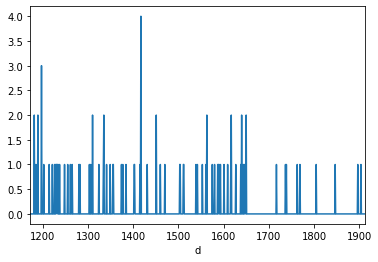

In [28]:
df_xy.iloc[200, :-28].plot()

In [31]:
df_xy.iloc[200, :-28].mean()

0.12264150943396226

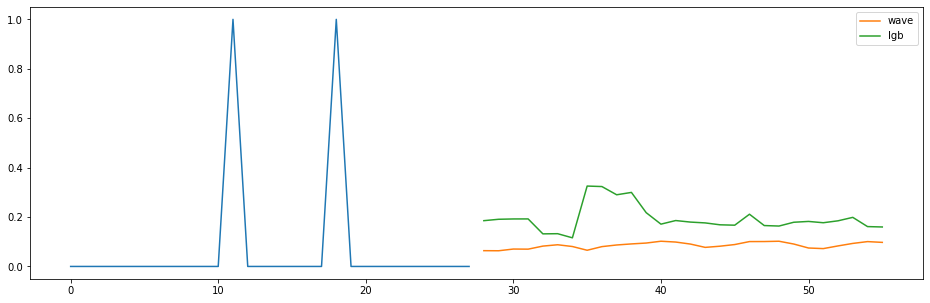

In [30]:
plot(200)

In [8]:
df_xy.mean(axis=1).mean()

1.2561647366396398

In [10]:
masked_xy = np.ma.array(np.log1p(df_xy).values, mask=(df_xy.values == 0) | (df_xy.isnull().values))
masked_xy.mean(axis=1).mean()

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


1.0215643845357223

In [14]:
np.log1p(df_xy).mean().mean()

C:\Users\evilp\AppData\Local\Continuum\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


0.46371134106875833

In [15]:
preds.mean()

NameError: name 'preds' is not defined

In [36]:
top1.iloc[:, 1:].mean().mean()

1.4331789663311454

In [35]:

# plt.figure(figsize=(16, 8))
# plt.plot(pd.read_csv("./data/submission_top1.csv").mean(1).iloc[:30490], alpha=0.5, label='lgb')
# plt.plot(pd.DataFrame(preds).mean(1), label='wave', alpha=0.5)
# plt.figure(figsize=(16, 2))
# plt.plot(df_xy.dropna(axis=1).iloc[:, -28:].mean(1).values, label='enc', alpha=0.5)
# plt.figure(figsize=(16, 2))
# plt.plot(df_xy.dropna(axis=1).iloc[:, ].mean(1).values, label='all', alpha=0.5)
# plt.figure(figsize=(16, 2))
# plt.plot(xy_mean)
# plt.legend()

In [24]:


# sort_id = pd.Series(dict(zip(np.arange(df_xy.shape[0]), sub_ids.sort_values().index.values))).values

# pd.DataFrame(preds[sort_id]).mean(axis=1)

# pd.DataFrame(preds).mean(axis=1)

# df_xy.mean(axis=1)

# pd.DataFrame({'sub_ids': sub_ids, 'xy_ids': xy_ids})

# pd.read_csv("./data/submission_top1.csv").set_index("id").mean().mean()

# pd.DataFrame(sub_ids).reset_index()

# xy_ids = pd.Series(df_xy.index.values)

# df_sub.iloc[: preds.shape[0], 1:] = preds
# df_sub.iloc[preds.shape[0]:, 1:] = preds

# df_sub.to_csv("./data/sub_0412_1.csv", index=None)

